<a href="https://colab.research.google.com/github/TejaPravs/Homework2/blob/main/Emotional_tone_prediction_in_movies_using_roberta.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fine Tuning Roberta for Emotional tone Prediction in Movies




**Introduction:**
In this project, I will be fine-tuning a RoBERTa model for Emotional Tone Prediction in Movies. Unlike traditional sentiment analysis, this project focuses on classifying nuanced emotional tones from movie descriptions, such as
humorous, inspiring, heartwarming, bittersweet, euphoric, melancholic, tense, romantic, nostalgic, intriguing, comforting, provocative, empowering, profound, enchanting, alarming, perilous, ominous, fearless, imaginative, methodical, investigative, intellectual, sophisticated, innovative, futuristic, wholesome, raw, and optimistic.

Since the dataset does not come with pre-labeled emotional tones, I generated these labels using the GPT-4o-mini API. This enriched dataset is then used to fine-tune a pre-trained RoBERTa model, enabling it to classify movie descriptions into one or more of these 29 emotional tones.

**Workflow of the Notebook:**
The notebook is organized into several sections, providing a clear walkthrough of the process used. This structure can be adapted for similar use cases. The sections are:

1.   Setting Up the Environment and Libraries
2.   Loading and Cleaning the Movie Dataset
3.   Building the Dataset for Model Training
4.   Defining the Model Architecture
5.   Training the Model with Fine-Tuning
6.   Evaluating Model Performance
7.   Saving the Trained Model for Future Use

**Technical Details:**
This project leverages various tools and resources to implement emotional tone prediction. Below are the key elements used. Ensure these are available in your environment to successfully run the notebook.

**Data:**

I am using the dataset available at Kaggle Movies Dataset.
Movie descriptions from this dataset are processed, and emotional tone labels are generated using the GPT-4o-mini API.
Language Model Used:

[The RoBERTa model, proposed](https://scholar.google.ca/citations?view_op=view_citation&hl=vi&user=H9buyroAAAAJ&citation_for_view=H9buyroAAAAJ:2osOgNQ5qMEC) in "RoBERTa: A Robustly Optimized BERT Pretraining Approach" by Yinhan Liu et al., is a robust language model optimized for NLP tasks.

**References:**

[Blog Post](https://ai.meta.com/blog/roberta-an-optimized-method-for-pretraining-self-supervised-nlp-systems/)

[Research Paper](https://arxiv.org/pdf/1907.11692)

[Documentation for Python](https://huggingface.co/docs/transformers/model_doc/roberta)

**Hardware Requirements:**
- Python version 3.10 or above
- PyTorch, Transformers, and standard Python ML libraries
- A GPU-enabled setup for efficient fine-tuning and evaluation
This notebook demonstrates how to prepare and fine-tune a model for emotional tone prediction, offering a flexible framework for similar classification tasks in NLP.

In [1]:
!pip install transformers
import transformers
print(transformers.__version__)

4.47.1


<a id='section01'></a>
### Importing Python Libraries and preparing the environment

In this section, I will import the essential libraries and modules required for the project.

These include:
*   Pandas: For data manipulation and analysis.
*   NumPy: For numerical operations.

*   scikit-learn: For dataset splitting and other utilities.

*   PyTorch: For building and training the model.

*   Transformers: For loading and fine-tuning the pre-trained RoBERTa model.

*   tqdm: For progress tracking during loops and data loading.

*   torch.utils.data: For managing datasets and dataloaders.

*   logging: For handling and suppressing unwanted log messages.


Finally, I configure the environment to utilize GPU (CUDA) if available. This ensures faster training and fine-tuning of the model by leveraging GPU capabilities.

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import torch
import seaborn as sns
import transformers
import json
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from transformers import RobertaModel, RobertaTokenizer
import random
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score, f1_score
import logging
logging.basicConfig(level=logging.ERROR)

In [3]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


In this section, I load, clean and preprocess the movie dataset to ensure it is ready for training the model. Here is a breakdown of the steps:

Firstly i have loaded the dataset using pandas and stored in 'movies_df'

**- Handling Missing Values in Descriptions:**

The overview column contains a placeholder text "No overview found." for missing movie descriptions. These entries are replaced with NaN values for easier handling.
I then remove rows with missing values in the overview column to ensure that all movies have a valid description.

**- Filtering Invalid Emotional Tone Labels:**

The emotional_tones column may contain invalid labels generated during preprocessing, such as error messages like "I'm sorry" or "Please provide."
To address this, I filter out rows where the emotional_tones column contains these phrases, keeping only valid rows.

**- Validating and Cleaning Emotional Tone Labels:**

I define a list of 29 valid emotional tones, such as humorous, inspiring, and bittersweet.
Each row in the emotional_tones column is processed to retain only tones that match the predefined list of valid tones. Any malformed or misspelled tones are removed.
After cleaning, I ensure no leading or trailing spaces remain and remove rows where the emotional_tones column is empty.

**- Verifying the Cleaned Data:**

After cleaning, I inspect the dataset to verify that:
All descriptions in the overview column are valid.
The emotional_tones column contains only valid emotional tones.
The dataset now has 14,943 rows with three columns: original_title, overview, and emotional_tones.

**- Extracting Unique Emotional Tones:**

I extract and sort all unique emotional tones from the cleaned dataset, confirming that the final list of tones matches the predefined valid tones.
These steps ensure the dataset is clean, consistent, and ready for use in training the model to predict emotional tones.

In [5]:
movies_df = pd.read_csv('/content/generated_emotional_tones.tsv', delimiter='\t')
movies_df = movies_df.rename(columns = {'Emotional_tones': 'emotional_tones'})

In [6]:
movies_df.shape

(15000, 3)

In [7]:
movies_df.head()

,original_title,overview,emotional_tones
0,All Tomorrow's Parties,A kaleidoscopic journey into the parallel musi...,"intriguing, imaginative, euphoric, enchanting"
1,Troy,"In year 1250 B.C. during the late Bronze age, ...","romantic, perilous, tense, fearless"
2,Varieté,The murderer “Boss” Huller – after having spen...,"intriguing, melancholic, raw, investigative"
3,Silenced,Only 11 Americans have ever been charged under...,"provocative, empowering, intellectual, investi..."
4,Alexander Graham Bell: The Sound and the Silence,True story of Alexander Graham Bell's inventio...,"inspiring, nostalgic, profound, innovative"


In [8]:
movies_df.describe()

,original_title,overview,emotional_tones
count,15000,15000,15000
unique,14724,14942,6314
top,Wuthering Heights,No overview found.,"tense, ominous, intriguing, perilous"
freq,5,47,155


In [9]:
import numpy as np

movies_df['overview'] = movies_df['overview'].replace('No overview found.', np.nan)

print(movies_df.isna().sum())

movies_df = movies_df.dropna(subset = ['overview'])

print()

print(movies_df.isna().sum())

print(movies_df.shape)

original_title      0
overview           47
emotional_tones     0
dtype: int64

original_title     0
overview           0
emotional_tones    0
dtype: int64
(14953, 3)


In [10]:
invalid_phrases = [
    "I'm sorry",
    "It looks like",
    "It seems",
    "Please provide",
    "Sure!"
]

movies_df = movies_df[~movies_df['emotional_tones'].str.contains('|'.join(invalid_phrases), na=False)]

In [11]:
print(movies_df.shape)

print(movies_df.head())

(14943, 3)
                                     original_title  \
0                            All Tomorrow's Parties   
1                                              Troy   
2                                           Varieté   
3                                          Silenced   
4  Alexander Graham Bell: The Sound and the Silence   

                                            overview  \
0  A kaleidoscopic journey into the parallel musi...   
1  In year 1250 B.C. during the late Bronze age, ...   
2  The murderer “Boss” Huller – after having spen...   
3  Only 11 Americans have ever been charged under...   
4  True story of Alexander Graham Bell's inventio...   

                                     emotional_tones  
0      intriguing, imaginative, euphoric, enchanting  
1                romantic, perilous, tense, fearless  
2        intriguing, melancholic, raw, investigative  
3  provocative, empowering, intellectual, investi...  
4         inspiring, nostalgic, profound, inno

In [12]:
valid_tones = ['humorous', 'inspiring', 'heartwarming', 'bittersweet', 'euphoric', 'melancholic', 'tense', 'romantic',
               'nostalgic', 'intriguing', 'comforting', 'provocative', 'empowering', 'profound', 'enchanting', 'alarming', 'perilous', 'ominous',
               'fearless', 'imaginative', 'methodical', 'investigative', 'intellectual', 'sophisticated', 'innovative', 'futuristic', 'wholesome', 'raw', 'optimistic']


def filter_tones(tones):
    return ", ".join(tone.strip() for tone in tones.split(", ") if tone.strip() in valid_tones)


movies_df['emotional_tones'] = movies_df['emotional_tones'].apply(filter_tones)

In [13]:
unique_cleaned_tones = sorted(
    set(tone for tones in movies_df['emotional_tones'].str.split(", ") for tone in tones if tone.strip())
)

print(unique_cleaned_tones)

['alarming', 'bittersweet', 'comforting', 'empowering', 'enchanting', 'euphoric', 'fearless', 'futuristic', 'heartwarming', 'humorous', 'imaginative', 'innovative', 'inspiring', 'intellectual', 'intriguing', 'investigative', 'melancholic', 'methodical', 'nostalgic', 'ominous', 'optimistic', 'perilous', 'profound', 'provocative', 'raw', 'romantic', 'sophisticated', 'tense', 'wholesome']


In [14]:
def clean_tones(tones):
    valid = [tone for tone in tones.split(", ") if tone.strip() in valid_tones]
    return ", ".join(valid)

movies_df['emotional_tones'] = movies_df['emotional_tones'].apply(clean_tones)

In [15]:
movies_df['emotional_tones'] = movies_df['emotional_tones'].str.strip()
movies_df = movies_df[movies_df['emotional_tones'] != '']

**Tokenization and Filtering**

In this step, I prepare the dataset for training by ensuring descriptions are detailed enough for meaningful analysis:

**Tone Mapping:** Each of the 29 emotional tones is mapped to a unique numeric value using a dictionary (tone_to_num).

**Tokenization:** Movie descriptions are tokenized using the RoBERTa tokenizer to count the number of tokens, including special tokens like [CLS] and [SEP].

**Filtering Short Descriptions:** Descriptions with fewer than 50 tokens are removed, as they may lack sufficient context for accurate tone classification.

**Final Dataset:** After filtering, the dataset has 9,192 rows with detailed movie descriptions ready for training.

In [16]:
from collections import Counter

all_tones = [tone for label in movies_df['emotional_tones'] for tone in label.split(', ')]

tone_counts = Counter(all_tones)

print("Tone Frequencies:", tone_counts)

Tone Frequencies: Counter({'intriguing': 7727, 'bittersweet': 6476, 'tense': 5553, 'romantic': 4924, 'melancholic': 4430, 'humorous': 3401, 'empowering': 3103, 'perilous': 2959, 'inspiring': 2818, 'raw': 2497, 'provocative': 1981, 'ominous': 1930, 'nostalgic': 1551, 'profound': 1419, 'heartwarming': 1167, 'investigative': 1147, 'fearless': 740, 'intellectual': 651, 'innovative': 635, 'alarming': 582, 'imaginative': 577, 'comforting': 440, 'enchanting': 430, 'sophisticated': 383, 'euphoric': 355, 'wholesome': 230, 'methodical': 113, 'optimistic': 97, 'futuristic': 58})


In [17]:
best_thresholds = {0: 0.07936195, 1: 0.23974839, 2: 0.13702092, 3: 0.20741107, 4: 0.19998576, 5: 0.14655237, 6: 0.23158349, 7: 0.013496702, 8: 0.1756147, 9: 0.4261986, 10: 0.2527687, 11: 0.17463294, 12: 0.18277569, 13: 0.07934828, 14: 0.63972485, 15: 0.28934807, 16: 0.25687066, 17: 0.04399931, 18: 0.30334944, 19: 0.32199684, 20: 0.03274795, 21: 0.3449805, 22: 0.19092746, 23: 0.44928926, 24: 0.26942602, 25: 0.51768124, 26: 0.15846977, 27: 0.46186405, 28: 0.031842932}

In [18]:
median_threshold = sorted(best_thresholds.values())[len(best_thresholds) // 2]
print(f"Median Threshold: {median_threshold}")

Median Threshold: 0.20741107


In [19]:
rare_tones = [tone_idx for tone_idx, threshold in best_thresholds.items() if threshold < median_threshold]
print(f"Rare Tone Indices: {rare_tones}")

Rare Tone Indices: [0, 2, 4, 5, 7, 8, 11, 12, 13, 17, 20, 22, 26, 28]


In [79]:
idx_to_tone = {
    0: 'alarming', 1: 'bittersweet', 2: 'comforting', 3: 'empowering',
    4: 'enchanting', 5: 'euphoric', 6: 'fearless', 7: 'futuristic',
    8: 'heartwarming', 9: 'humorous', 10: 'imaginative', 11: 'innovative',
    12: 'inspiring', 13: 'intellectual', 14: 'intriguing', 15: 'investigative',
    16: 'melancholic', 17: 'methodical', 18: 'nostalgic', 19: 'ominous',
    20: 'optimistic', 21: 'perilous', 22: 'profound', 23: 'provocative',
    24: 'raw', 25: 'romantic', 26: 'sophisticated', 27: 'tense', 28: 'wholesome'
}

rare_tone_names = [idx_to_tone[idx] for idx in rare_tones]
print(f"Rare Tone Names: {rare_tone_names}")

def sample_with_replacement(dataframe, tones_column, rare_tones, sample_size=2):
    rare_rows = dataframe[dataframe[tones_column].apply(
        lambda tones: any(tone in tones.split(', ') for tone in rare_tones)
    )]

    print(f"Number of rows with rare tones: {len(rare_rows)}")

    if len(rare_rows) > 0:
        sampled_rows = rare_rows.sample(n=len(rare_rows) * sample_size, replace=True, random_state=42)
        return sampled_rows
    else:
        print("No rows with rare tones found.")
        return pd.DataFrame(columns=dataframe.columns)  # Return empty DataFrame if no rare rows found



Rare Tone Names: ['alarming', 'comforting', 'enchanting', 'euphoric', 'futuristic', 'heartwarming', 'innovative', 'inspiring', 'intellectual', 'methodical', 'optimistic', 'profound', 'sophisticated', 'wholesome']


In [21]:
sampled_data = sample_with_replacement(movies_df, 'emotional_tones', rare_tone_names, sample_size=2)

augmented_movies_df = pd.concat([movies_df, sampled_data], ignore_index=True)

print(f"Original Dataset Size: {len(movies_df)}")
print(f"Augmented Dataset Size: {len(augmented_movies_df)}")

Number of rows with rare tones: 6905
Original Dataset Size: 14943
Augmented Dataset Size: 28753


In [22]:
print(augmented_movies_df.shape)
print(augmented_movies_df.head())

(28753, 3)
                                     original_title  \
0                            All Tomorrow's Parties   
1                                              Troy   
2                                           Varieté   
3                                          Silenced   
4  Alexander Graham Bell: The Sound and the Silence   

                                            overview  \
0  A kaleidoscopic journey into the parallel musi...   
1  In year 1250 B.C. during the late Bronze age, ...   
2  The murderer “Boss” Huller – after having spen...   
3  Only 11 Americans have ever been charged under...   
4  True story of Alexander Graham Bell's inventio...   

                                     emotional_tones  
0      intriguing, imaginative, euphoric, enchanting  
1                romantic, perilous, tense, fearless  
2        intriguing, melancholic, raw, investigative  
3  provocative, empowering, intellectual, investi...  
4         inspiring, nostalgic, profound, inno

In [23]:
tones = ['alarming', 'bittersweet', 'comforting', 'empowering', 'enchanting', 'euphoric', 'fearless', 'futuristic', 'heartwarming', 'humorous', 'imaginative', 'innovative', 'inspiring', 'intellectual', 'intriguing', 'investigative', 'melancholic', 'methodical', 'nostalgic', 'ominous', 'optimistic', 'perilous', 'profound', 'provocative', 'raw', 'romantic', 'sophisticated', 'tense', 'wholesome']

tone_to_num = {}
for idx, tone in enumerate(tones):
    tone_to_num[tone] = idx
print(tone_to_num)

{'alarming': 0, 'bittersweet': 1, 'comforting': 2, 'empowering': 3, 'enchanting': 4, 'euphoric': 5, 'fearless': 6, 'futuristic': 7, 'heartwarming': 8, 'humorous': 9, 'imaginative': 10, 'innovative': 11, 'inspiring': 12, 'intellectual': 13, 'intriguing': 14, 'investigative': 15, 'melancholic': 16, 'methodical': 17, 'nostalgic': 18, 'ominous': 19, 'optimistic': 20, 'perilous': 21, 'profound': 22, 'provocative': 23, 'raw': 24, 'romantic': 25, 'sophisticated': 26, 'tense': 27, 'wholesome': 28}


In [24]:
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)
def token_count(text, tokenizer):
    return len(tokenizer.encode(text, add_special_tokens=True, truncation = True))


augmented_movies_df['token_count'] = augmented_movies_df['overview'].apply(lambda x: token_count(x, tokenizer))


augmented_movies_df = augmented_movies_df[augmented_movies_df['token_count'] >= 50]


augmented_movies_df = augmented_movies_df.drop(columns=['token_count'])

print(augmented_movies_df.shape)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

(17782, 3)


In [25]:
max_token_length = 256
train_batch_size = 16
valid_batch_size = 16
learning_rate = 2e-05
tokenizer = RobertaTokenizer.from_pretrained('roberta-base', truncation=True, do_lower_case=True)

<a id='section03'></a>
### Preparing the Dataset and Dataloader

I will begin by defining a few key variables that will be used during the training and fine-tuning process. After that, I will create a Dataset class, which is responsible for preprocessing the data before it is sent to the neural network. Additionally, I will define a Dataloader that feeds the data to the neural network in batches, ensuring efficient training and processing.

The Dataset and Dataloader are core components of the PyTorch library. They provide a structured way to preprocess data and manage how it flows into the model during training. To learn more about Datasets and Dataloaders, you can refer to the [PyTorch documentation](https://pytorch.org/docs/stable/data.html).

#### *EmotionalToneData* Dataset Class
This custom Dataset class processes the movie dataset and prepares it for training and evaluation. Key features include:

**Input: **

**The class accepts:**
A DataFrame containing movie descriptions and emotional tones.
A tokenizer for text processing.
Parameters like max_len for token sequence length.
Tokenization:
The RoBERTa tokenizer is used to tokenize the overview (movie description) column.

**RoBERTa Tokeniser generates:**

**ids:** Tokenized representation of the text.

**attention_mask:** Identifies which tokens are meaningful.

**token_type_ids:** Differentiates sequences (optional here).

**Label Encoding:**
Emotional tones are converted into a binary vector of size 29.

Each tone in the description is represented by a 1 at its corresponding index, with the rest as 0.

**Datasets:**

**Training Dataset:** Comprises 80% of the original data for fine-tuning.
**Validation Dataset:** The remaining 20%, unseen during training, is used to evaluate model performance.

For more on tokenization, refer to the RoBERTa Tokenizer documentation.

#### Dataloader

The Dataloader ensures smooth data processing and loading during model training:

**Purpose:** Controls the size and sequence of data passed to the model, preventing memory overload.

**Parameters:**

**batch_size:** Defines the number of samples per batch.

**shuffle:** Randomizes data in the training Dataloader for better generalization.

**num_workers:** Specifies the number of processes for parallel data loading.

**Training and Validation Loaders:**

**Training Loader:** Feeds shuffled batches of data for model training.

**Validation Loader:** Sequentially feeds batches for evaluation.

This streamlined setup ensures that the data is efficiently processed and fed to the model, optimizing training and evaluation workflows.

In [26]:
class EmotionalToneData(Dataset):
    def __init__(self, dataframe, tokenizer, max_len, tone_to_num):
        self.tokenizer = tokenizer
        self.tone_to_num = tone_to_num
        self.data = dataframe
        self.text = dataframe.overview
        self.targets = dataframe.emotional_tones
        self.max_len = 256

    def __len__(self):
        return len(self.text)


    def __getitem__(self, index):
        text = str(self.text[index])
        text = " ".join(text.split())
        inputs = self.tokenizer.encode_plus(
        text,
        None,
        add_special_tokens=True,
        max_length=self.max_len,
        padding = 'max_length',
        truncation = True,
        return_token_type_ids=True
        )
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs['token_type_ids']

        tone_labels = [self.tone_to_num.get(tone_str, None) for tone_str in self.targets[index].split(", ")]
        tone_labels = [tl for tl in tone_labels if tl is not None]
        bce_labels = [0] * len(self.tone_to_num)
        for tl in tone_labels:
            bce_labels[tl] = 1

        return {
        'ids': torch.tensor(ids, dtype=torch.long),
        'mask': torch.tensor(mask, dtype=torch.long),
        'token_type_ids': torch.tensor(token_type_ids, dtype=torch.long),
        'targets': torch.tensor(bce_labels, dtype=torch.long)
        }


In [28]:
train_size = 0.8
train_data = augmented_movies_df.sample(frac=train_size,random_state=200)
test_data = augmented_movies_df.drop(train_data.index).reset_index(drop=True)
train_data = train_data.reset_index(drop=True)

print("FULL Dataset: {}".format(augmented_movies_df.shape))
print("TRAIN Dataset: {}".format(train_data.shape))
print("TEST Dataset: {}".format(test_data.shape))

training_set = EmotionalToneData(train_data, tokenizer, max_token_length, tone_to_num)
testing_set = EmotionalToneData(test_data, tokenizer, max_token_length, tone_to_num)

FULL Dataset: (17782, 3)
TRAIN Dataset: (14226, 3)
TEST Dataset: (3556, 3)


In [80]:
def seed_worker(worker_id):
    seed = 42
    np.random.seed(seed + worker_id)
    random.seed(seed + worker_id)
    torch.manual_seed(seed + worker_id)

In [31]:
train_params = {
    'batch_size': train_batch_size,
    'shuffle': True,
    'num_workers': 0,
    'worker_init_fn': seed_worker
}

test_params = {
    'batch_size': valid_batch_size,
    'shuffle': False,
    'num_workers': 0,
    'worker_init_fn': seed_worker
}

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)


In [32]:
train_params = {'batch_size': train_batch_size,
                'shuffle': True,
                'num_workers': 0
                }

test_params = {'batch_size': valid_batch_size,
                'shuffle': True,
                'num_workers': 0
                }

training_loader = DataLoader(training_set, **train_params)
testing_loader = DataLoader(testing_set, **test_params)

<a id='section04'></a>
### Creating the Neural Network for Fine Tuning

#### Neural Network
**RobertaClass:**
In this project, I create a custom neural network, RobertaClass, which builds on the pre-trained RoBERTa language model. The architecture includes:

**RoBERTa Language Model:**

The core of the network uses the pre-trained roberta-base model, which processes the input text to extract meaningful features.

**Pre-Classifier Layer:**

A fully connected linear layer with 768 units is added to refine the output from the RoBERTa model.

**Dropout Layer:**

A dropout layer with a 0.2 probability is used to reduce overfitting by randomly deactivating some neurons during training.

**Classifier Layer:**

The final layer is a linear layer with 29 output units, corresponding to the

* The final layer is a linear layer with 29 output units, corresponding to the 29 emotional tones. Each output represents the likelihood of the associated tone.

*  The network processes the tokenized data from the Dataset class and outputs probabilities for each emotional tone. These outputs are then compared to the actual labels to calculate the accuracy of the model.

#### Loss Function and Optimizer

**Loss Function:**

The BCEWithLogitsLoss (Binary Cross-Entropy with Logits Loss) is used which is well-suited for multi-label classification tasks as it calculates the error between the predicted probabilities and the actual multi-label targets.
This function combines a sigmoid activation with binary cross-entropy, making it efficient for training.

**Optimizer:**
The Adam optimizer is used to update the weights of the network during training. It adjusts the weights based on the calculated loss, helping the model improve its predictions over time.

In [33]:
class RobertaClass(torch.nn.Module):
    def __init__(self):
        super(RobertaClass, self).__init__()
        self.l1 = RobertaModel.from_pretrained("roberta-base")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.2)
        self.classifier = torch.nn.Linear(768, 29)

    def forward(self, input_ids, attention_mask, token_type_ids):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.ReLU()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output

In [34]:
model = RobertaClass()
model.to(device)

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


RobertaClass(
  (l1): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [35]:
loss_function = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params =  model.parameters(), lr=learning_rate)

<a id='section05'></a>
### Training the Model with Fine-Tuning

**Training Process**
The RobertaClass model was fine-tuned over three epochs using the following steps:

**Batch Processing:**
Data was processed in batches using the training_loader for efficient memory use.

**Loss Calculation:**
Loss was computed using BCEWithLogitsLoss, ideal for multi-label classification.

**Weight Optimization:**
The Adam optimizer adjusted weights to minimize loss.

**Metrics Logging:**
Training loss and accuracy were recorded every 100 steps for monitoring.

**Validation Process:**

The valid function evaluated model performance on the validation dataset:

**Thresholds:**
Tone specific thresholds for each tone found by using the probablities, targets we got from validation.

**Metrics:**
Validation loss, accuracy, Precision, Recall, and F1 Score were calculated.

**Interpretability:**
Predictions were converted back into emotional tones for better understanding.


In [81]:
def set_seed(seed=42):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(seed=42)


In [82]:
def find_class_specific_thresholds(model, validation_loader):
    model.eval()
    all_probs = []
    all_targets = []

    with torch.no_grad():
        for data in validation_loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float32)

            logits = model(ids, mask, token_type_ids)
            probs = torch.sigmoid(logits)

            all_probs.extend(probs.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_probs = np.array(all_probs)
    all_targets = np.array(all_targets)

    thresholds = []
    avg_f1 = 0


    for tone_idx in range(all_probs.shape[1]):
        precision, recall, thresholds_list = precision_recall_curve(all_targets[:, tone_idx], all_probs[:, tone_idx])
        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
        best_idx = np.argmax(f1_scores)
        thresholds.append(thresholds_list[best_idx])
        avg_f1 += f1_scores[best_idx]

    avg_f1 /= all_probs.shape[1]
    return thresholds, avg_f1


In [83]:
def valid(model, validation_loader, thresholds):
    model.eval()
    tr_loss = 0
    all_preds = []
    all_targets = []
    all_probs = []

    with torch.no_grad():
        for data in validation_loader:
            ids = data['ids'].to(device, dtype=torch.long)
            mask = data['mask'].to(device, dtype=torch.long)
            token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
            targets = data['targets'].to(device, dtype=torch.float32)

            logits = model(ids, mask, token_type_ids)
            loss = loss_function(logits, targets)
            tr_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = torch.zeros_like(probs)
            for tone_idx, threshold in enumerate(thresholds):
                preds[:, tone_idx] = (probs[:, tone_idx] >= threshold).float()

            all_probs.extend(probs.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    valid_loss = tr_loss / len(validation_loader)
    valid_acc = (np.array(all_preds) == np.array(all_targets)).mean()

    precision = precision_score(all_targets, all_preds, average='samples', zero_division=1)
    recall = recall_score(all_targets, all_preds, average='samples', zero_division=1)
    f1 = f1_score(all_targets, all_preds, average='samples', zero_division=1)

    return valid_loss, valid_acc, precision, recall, f1


In [39]:
steps = []
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

class_specific_thresholds, avg_f1 = find_class_specific_thresholds(model, testing_loader)

for epoch in range(3):
    print(f"Epoch {epoch + 1}/3")
    model.train()

    tr_loss = 0
    epoch_acc = 0
    nb_tr_steps = 0

    for step, data in enumerate(training_loader, 1):
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float32)

        logits = model(ids, mask, token_type_ids)
        loss = loss_function(logits, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        tr_loss += loss.item()

        probs = torch.sigmoid(logits.detach().cpu())
        preds = torch.zeros_like(probs)
        for tone_idx, threshold in enumerate(class_specific_thresholds):
            preds[:, tone_idx] = (probs[:, tone_idx] >= threshold).float()
        batch_acc = (preds == targets.detach().cpu()).sum().item() / targets.numel()
        epoch_acc += batch_acc
        nb_tr_steps += 1

        if step % 100 == 0:
            train_loss = tr_loss / nb_tr_steps
            train_acc = epoch_acc / nb_tr_steps

            valid_loss, valid_acc, _, _, _ = valid(model, testing_loader, class_specific_thresholds)
            steps.append((epoch * len(training_loader)) + step)
            train_losses.append(train_loss)
            train_accuracies.append(train_acc)
            val_losses.append(valid_loss)
            val_accuracies.append(valid_acc)
            print(f"Step {step}: Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")
            print(f"Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")

    epoch_train_loss = tr_loss / nb_tr_steps
    epoch_train_acc = epoch_acc / nb_tr_steps
    valid_loss, valid_acc, precision, recall, f1 = valid(model, testing_loader, class_specific_thresholds)
    print(f"Epoch {epoch + 1} Training Loss: {epoch_train_loss:.4f}, Training Accuracy: {epoch_train_acc:.4f}")
    print(f"Epoch {epoch + 1} Validation Loss: {valid_loss:.4f}, Validation Accuracy: {valid_acc:.4f}")
    print(f"Validation Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}")
print("Training complete.")

Epoch 1/3
Step 100: Training Loss: 0.4563, Training Accuracy: 0.8401
Validation Loss: 0.3421, Validation Accuracy: 0.8641
Step 200: Training Loss: 0.3889, Training Accuracy: 0.8569
Validation Loss: 0.2916, Validation Accuracy: 0.8861
Step 300: Training Loss: 0.3516, Training Accuracy: 0.8688
Validation Loss: 0.2593, Validation Accuracy: 0.9005
Step 400: Training Loss: 0.3261, Training Accuracy: 0.8779
Validation Loss: 0.2376, Validation Accuracy: 0.9093
Step 500: Training Loss: 0.3066, Training Accuracy: 0.8849
Validation Loss: 0.2209, Validation Accuracy: 0.9171
Step 600: Training Loss: 0.2915, Training Accuracy: 0.8905
Validation Loss: 0.2082, Validation Accuracy: 0.9204
Step 700: Training Loss: 0.2787, Training Accuracy: 0.8952
Validation Loss: 0.2013, Validation Accuracy: 0.9233
Step 800: Training Loss: 0.2684, Training Accuracy: 0.8989
Validation Loss: 0.1893, Validation Accuracy: 0.9283
Epoch 1 Training Loss: 0.2603, Training Accuracy: 0.9020
Epoch 1 Validation Loss: 0.1877, Vali

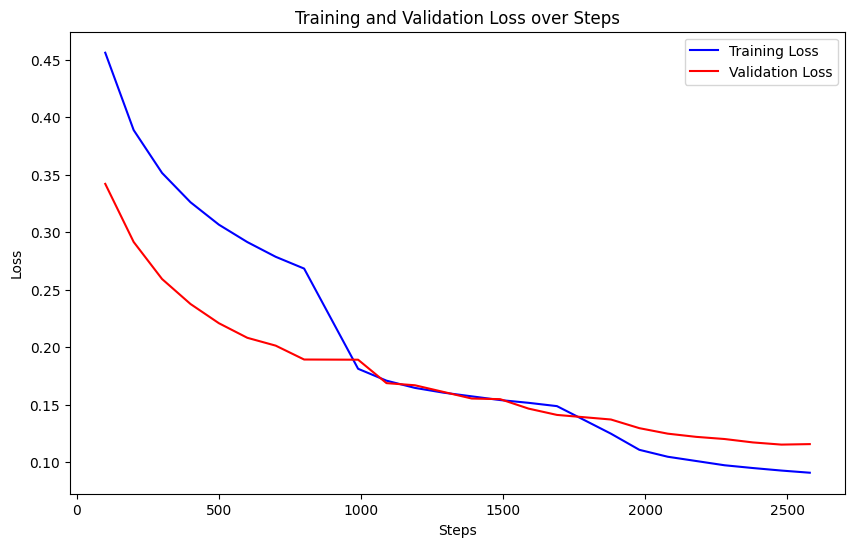

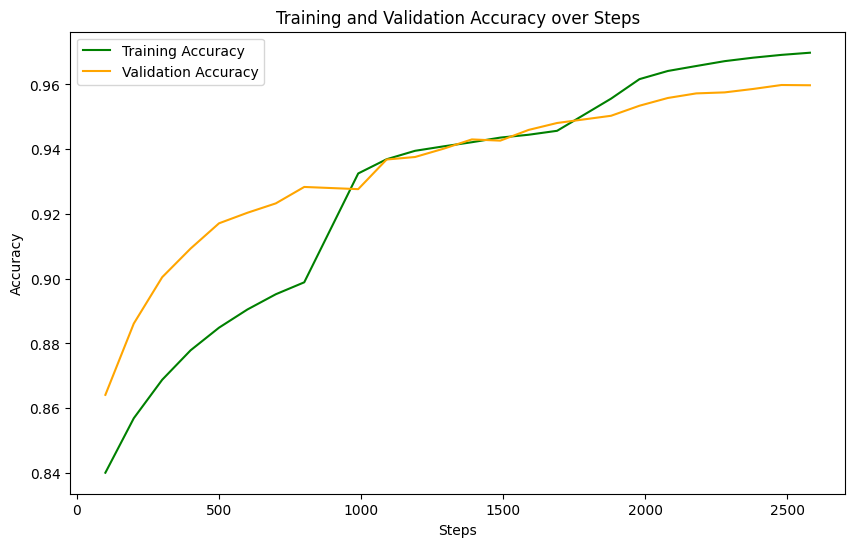

In [40]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(steps, train_losses, label='Training Loss', color='blue')
plt.plot(steps, val_losses, label='Validation Loss', color='red')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title('Training and Validation Loss over Steps')
plt.legend()
plt.savefig('loss_over_steps.png')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(steps, train_accuracies, label='Training Accuracy', color='green')
plt.plot(steps, val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy over Steps')
plt.legend()
plt.savefig('accuracy_over_steps.png')
plt.show()


In [41]:
logits

tensor([[-4.1999,  6.6631, -4.9930, -3.5839, -7.9209, -7.8362, -5.2557, -7.9171,
         -6.3435, -4.5614, -8.3170, -3.6101, -6.9921, -3.7047, -2.7487, -7.2864,
          1.8263, -6.8167, -7.1358, -4.5382, -8.8121, -6.6498, -6.5941, -2.0337,
         -2.4946,  3.8788, -6.7333,  1.6941, -8.6011],
        [-4.1742, -4.9690, -7.7220, -1.0501, -8.0652, -6.8901, -3.3628, -6.4888,
         -7.1716, -6.2216, -7.1339, -3.6406, -5.3951, -3.2925, -3.0153,  1.4282,
         -1.5090, -4.0326, -6.3173, -0.3896, -7.4647, -3.5201,  0.3120, -0.8875,
         -5.4236, -5.8068, -6.3181,  6.3707, -8.1371]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [42]:
targets

tensor([[0., 1., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 1., 0., 1., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
         0., 1., 0., 0., 0., 0., 0., 0., 0., 1., 0.]], device='cuda:0')

In [43]:
probs = torch.sigmoid(logits)
print(probs)

tensor([[1.4776e-02, 9.9872e-01, 6.7398e-03, 2.7017e-02, 3.6295e-04, 3.9501e-04,
         5.1904e-03, 3.6432e-04, 1.7550e-03, 1.0340e-02, 2.4426e-04, 2.6336e-02,
         9.1827e-04, 2.4017e-02, 6.0158e-02, 6.8434e-04, 8.6132e-01, 1.0942e-03,
         7.9548e-04, 1.0580e-02, 1.4890e-04, 1.2927e-03, 1.3665e-03, 1.1571e-01,
         7.6237e-02, 9.7974e-01, 1.1892e-03, 8.4476e-01, 1.8387e-04],
        [1.5154e-02, 6.9021e-03, 4.4277e-04, 2.5920e-01, 3.1420e-04, 1.0168e-03,
         3.3480e-02, 1.5181e-03, 7.6748e-04, 1.9821e-03, 7.9696e-04, 2.5565e-02,
         4.5184e-03, 3.5830e-02, 4.6740e-02, 8.0662e-01, 1.8109e-01, 1.7419e-02,
         1.8016e-03, 4.0381e-01, 5.7261e-04, 2.8746e-02, 5.7738e-01, 2.9163e-01,
         4.3918e-03, 2.9981e-03, 1.8000e-03, 9.9829e-01, 2.9239e-04]],
       device='cuda:0', grad_fn=<SigmoidBackward0>)


In [64]:
all_targets = []
all_probs = []

model.eval()
with torch.no_grad():
    for data in testing_loader:
        ids = data['ids'].to(device, dtype=torch.long)
        mask = data['mask'].to(device, dtype=torch.long)
        token_type_ids = data['token_type_ids'].to(device, dtype=torch.long)
        targets = data['targets'].to(device, dtype=torch.float32)

        logits = model(ids, mask, token_type_ids)
        probs = torch.sigmoid(logits)

        all_probs.extend(probs.cpu().numpy())
        all_targets.extend(targets.cpu().numpy())

In [84]:
def find_best_thresholds(all_targets, all_probs):
    best_thresholds = []

    for tone_idx in range(all_targets.shape[1]):
        y_true = all_targets[:, tone_idx]
        y_probs = all_probs[:, tone_idx]
        precision, recall, thresholds = precision_recall_curve(y_true, y_probs)

        f1_scores = 2 * (precision * recall) / (precision + recall + 1e-7)
        f1_scores = np.nan_to_num(f1_scores, nan=0.0)
        best_idx = np.argmax(f1_scores)
        best_thresholds.append(thresholds[best_idx])
    return best_thresholds

In [58]:
from sklearn.metrics import precision_recall_curve, auc
pr_curves = {}
for tone_idx in range(len(tone_to_num)):
    y_true = np.array(all_targets)[:, tone_idx]
    y_probs = np.array(all_probs)[:, tone_idx]

    precision, recall, thresholds = precision_recall_curve(y_true, y_probs)
    auc_pr = auc(recall, precision)

    pr_curves[tone_idx] = {
        'precision': precision,
        'recall': recall,
        'thresholds': thresholds,
        'auc': auc_pr
    }

In [ ]:
best_thresholds = {}
for tone_idx, pr_data in pr_curves.items():
    precision, recall, thresholds = pr_data['precision'], pr_data['recall'], pr_data['thresholds']
    with np.errstate(divide='ignore', invalid='ignore'):
        f1_scores = 2 * (precision * recall) / (precision + recall)
        f1_scores = np.nan_to_num(f1_scores, nan=0.0)
    best_idx = f1_scores.argmax()
    best_thresholds[tone_idx] = thresholds[best_idx]

print("Best thresholds per tone:", best_thresholds)

In [50]:
for tone_idx, pr_data in pr_curves.items():
    best_threshold = best_thresholds[tone_idx]
    thresholds = pr_data['thresholds']
    best_idx = (thresholds == best_threshold).nonzero()[0][0]
    best_precision = pr_data['precision'][best_idx]
    best_recall = pr_data['recall'][best_idx]

    print(f"Tone {tone_idx}:")
    print(f"  Best Threshold: {best_threshold}")
    print(f"  Precision at Best Threshold: {best_precision}")
    print(f"  Recall at Best Threshold: {best_recall}")
    print()

Tone 0:
  Best Threshold: 0.3805871903896332
  Precision at Best Threshold: 0.8855421686746988
  Recall at Best Threshold: 0.901840490797546

Tone 1:
  Best Threshold: 0.3728192448616028
  Precision at Best Threshold: 0.9351256575102279
  Recall at Best Threshold: 0.9318578916715201

Tone 2:
  Best Threshold: 0.3588859438896179
  Precision at Best Threshold: 0.75177304964539
  Recall at Best Threshold: 0.7019867549668874

Tone 3:
  Best Threshold: 0.3850608766078949
  Precision at Best Threshold: 0.642023346303502
  Recall at Best Threshold: 0.6156716417910447

Tone 4:
  Best Threshold: 0.49169686436653137
  Precision at Best Threshold: 0.8897058823529411
  Recall at Best Threshold: 0.8832116788321168

Tone 5:
  Best Threshold: 0.15778571367263794
  Precision at Best Threshold: 0.8780487804878049
  Recall at Best Threshold: 0.8780487804878049

Tone 6:
  Best Threshold: 0.4205192029476166
  Precision at Best Threshold: 0.7784090909090909
  Recall at Best Threshold: 0.6989795918367347

T

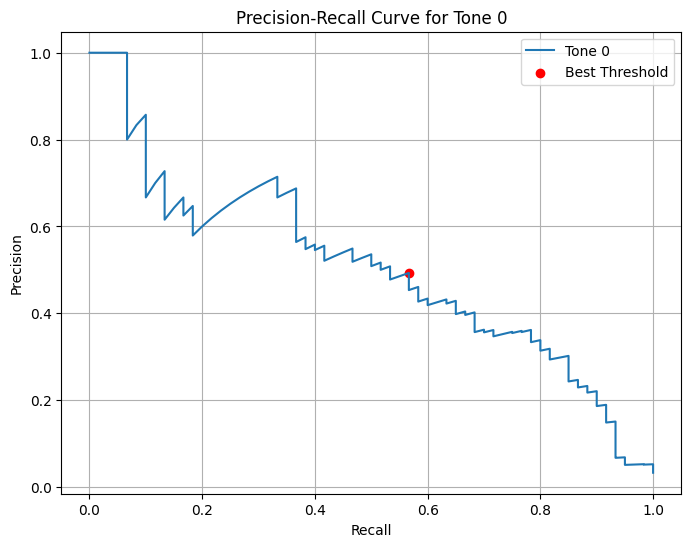

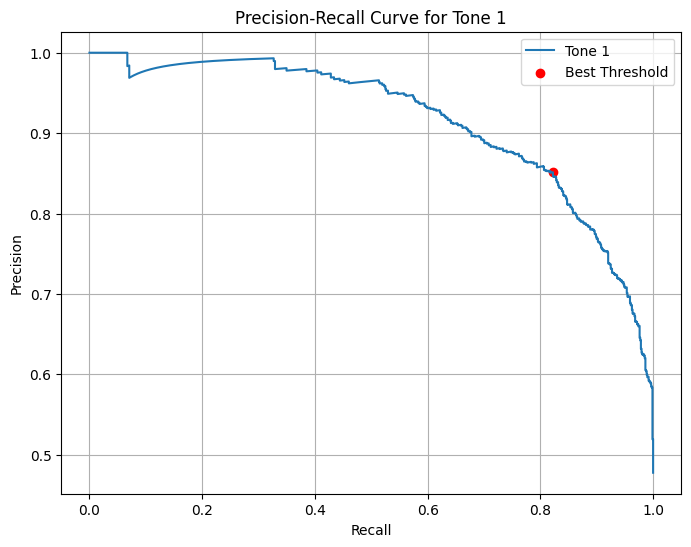

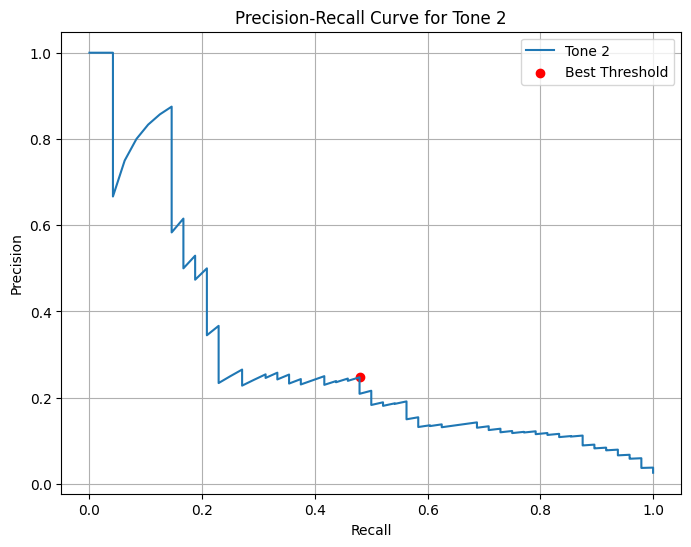

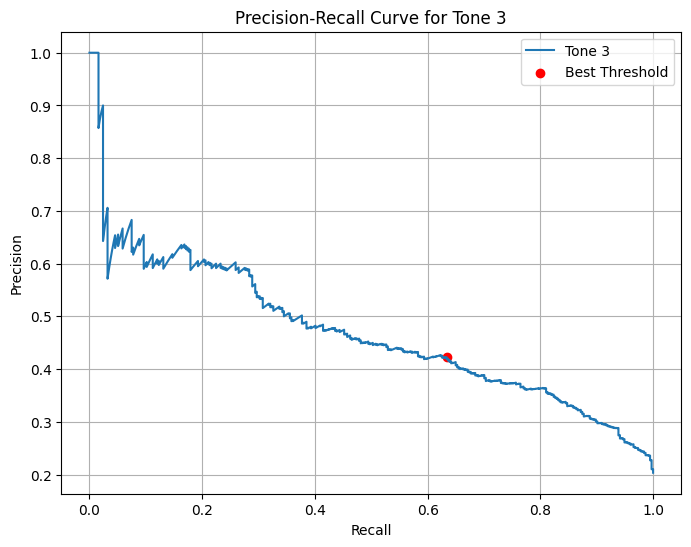

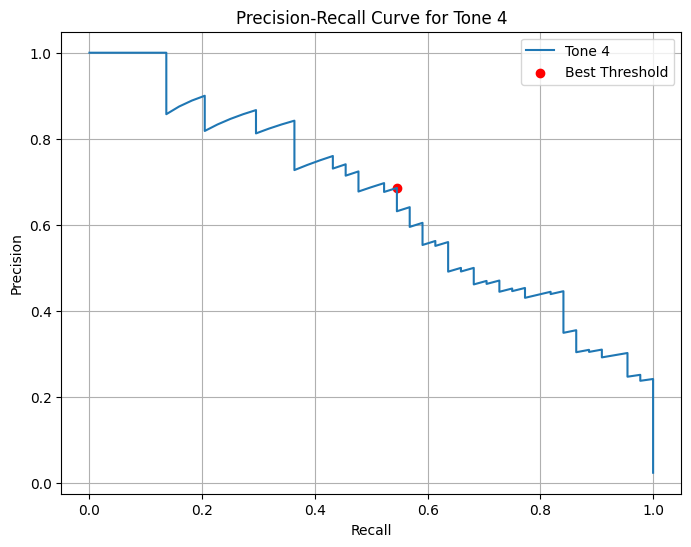

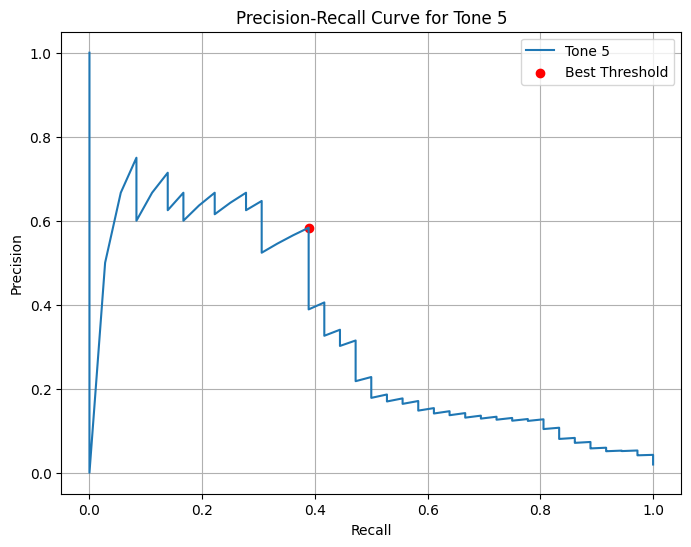

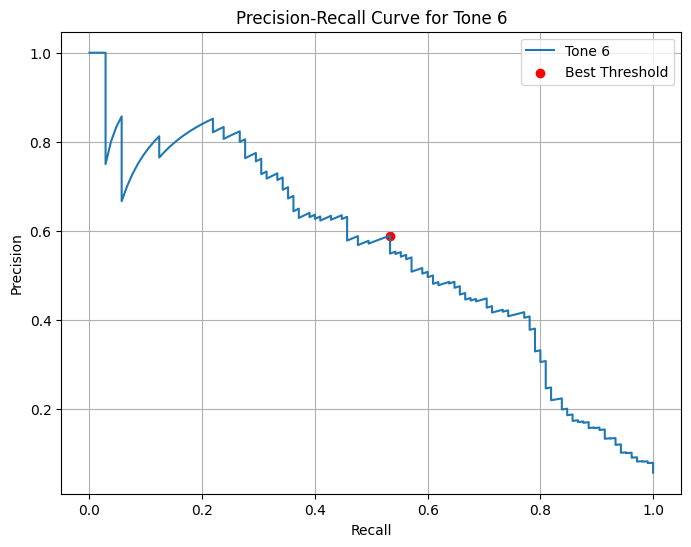

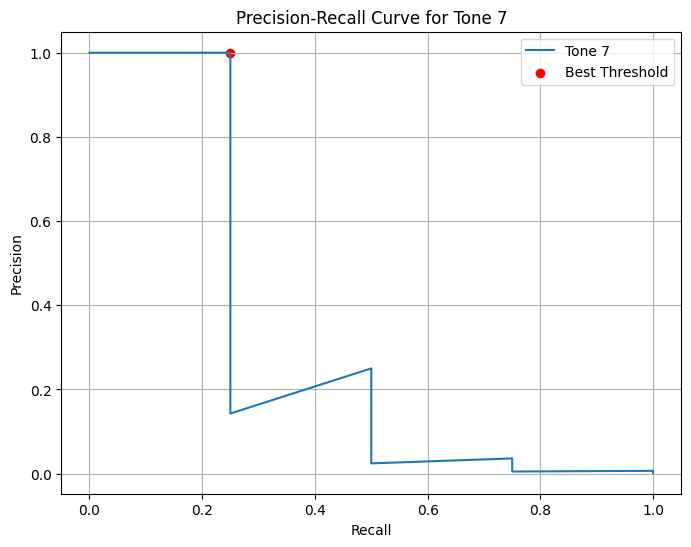

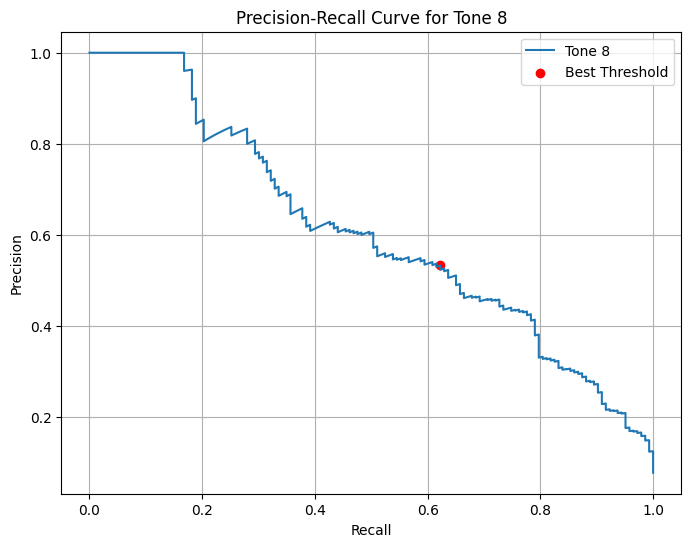

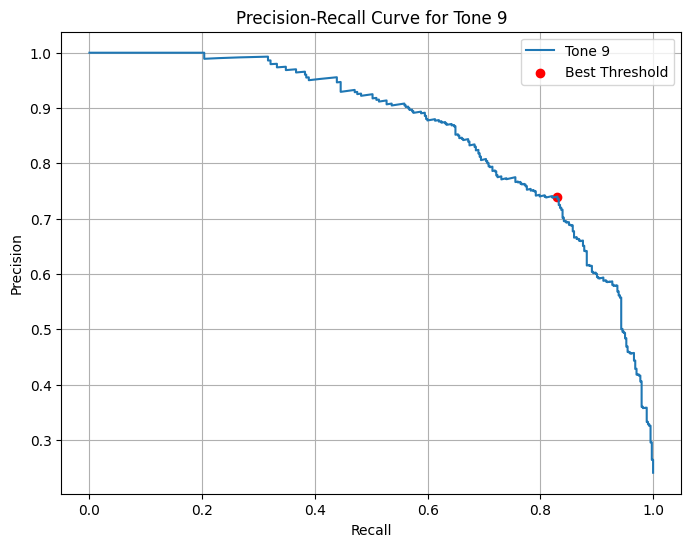

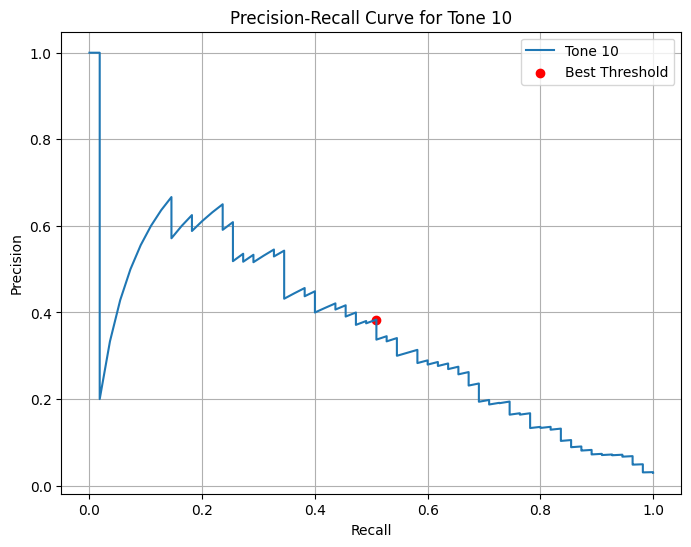

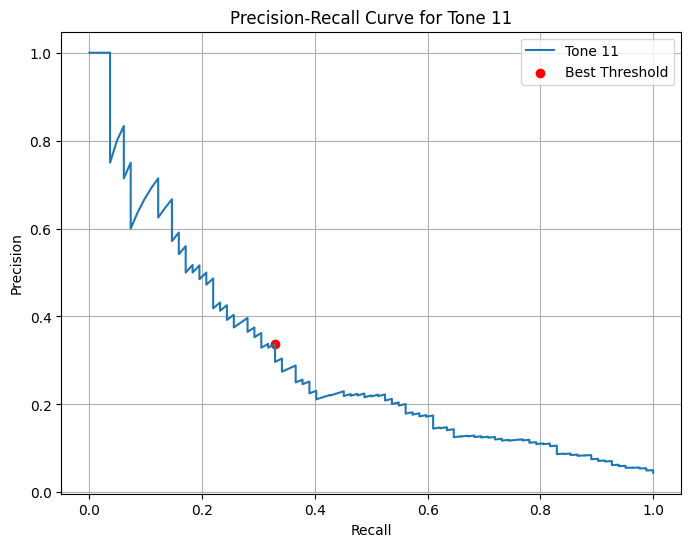

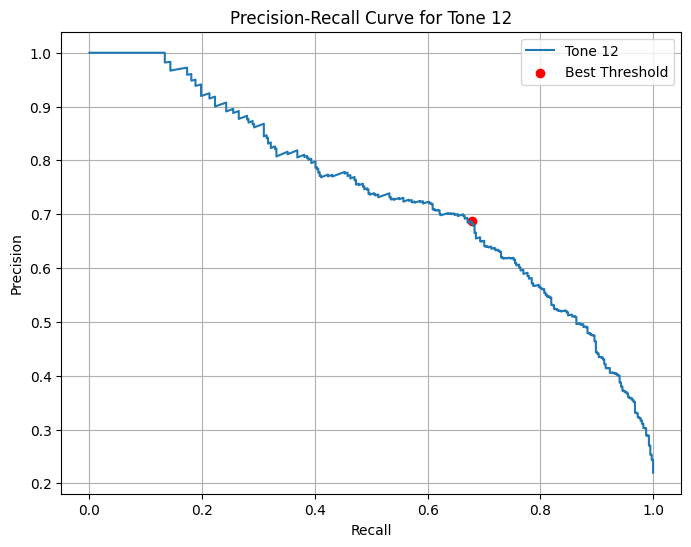

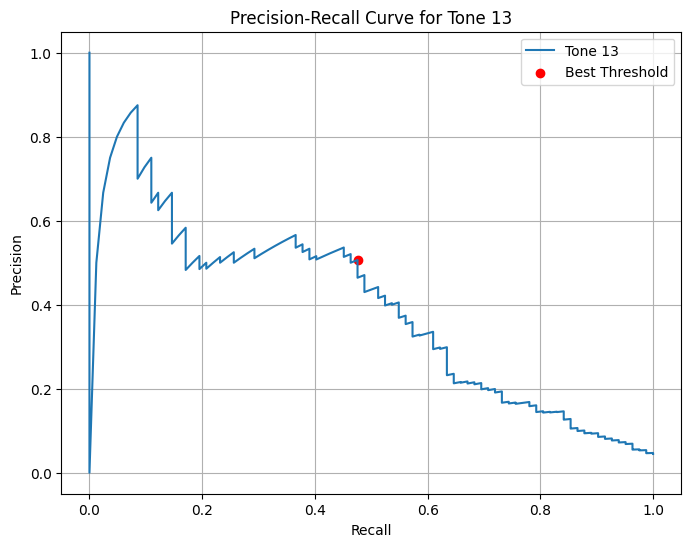

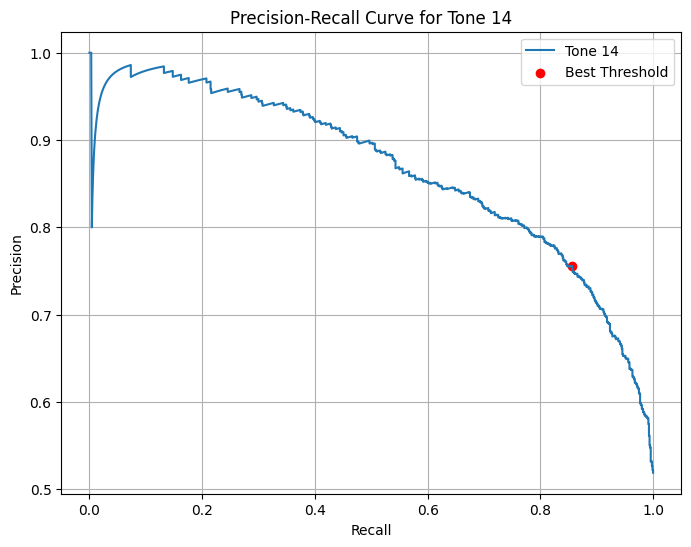

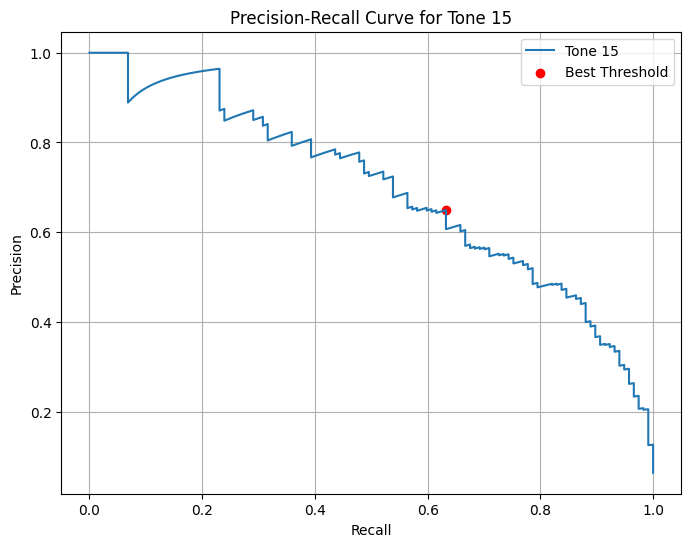

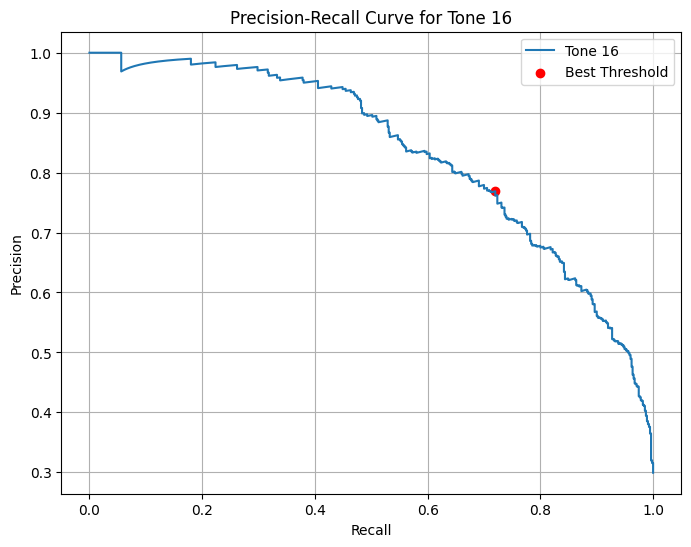

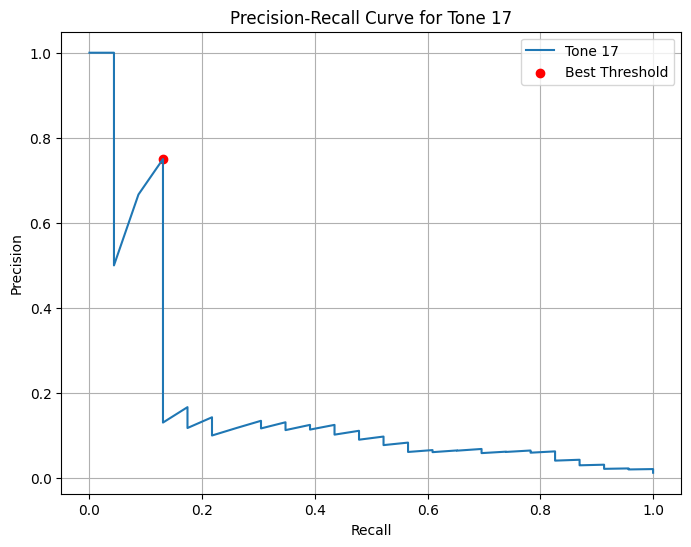

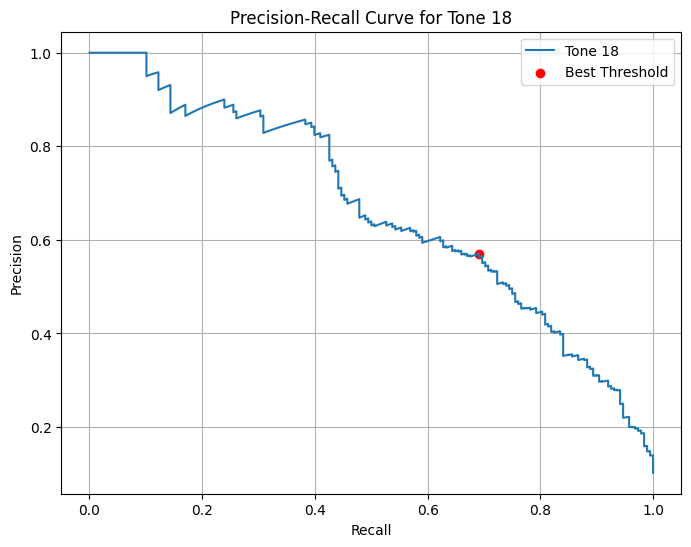

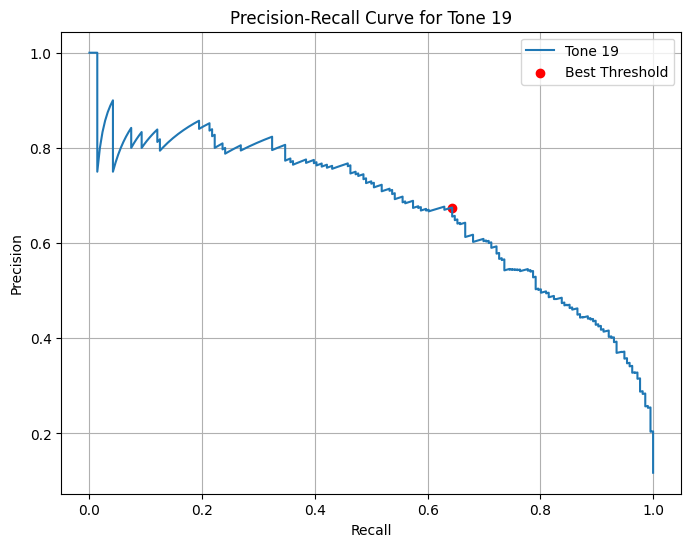

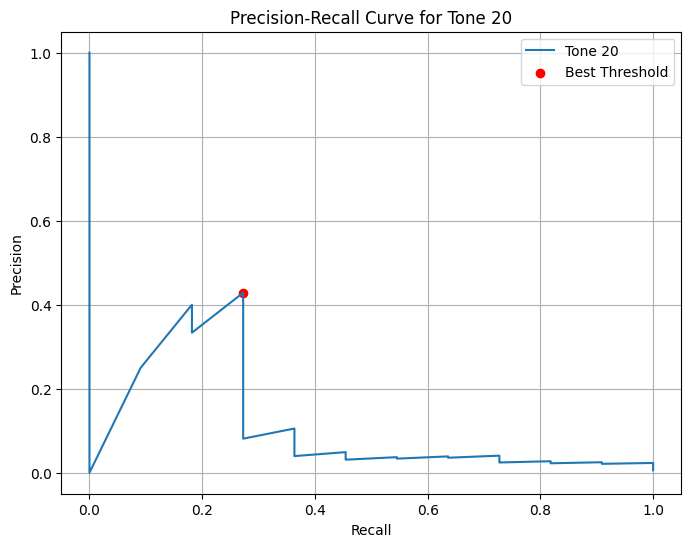

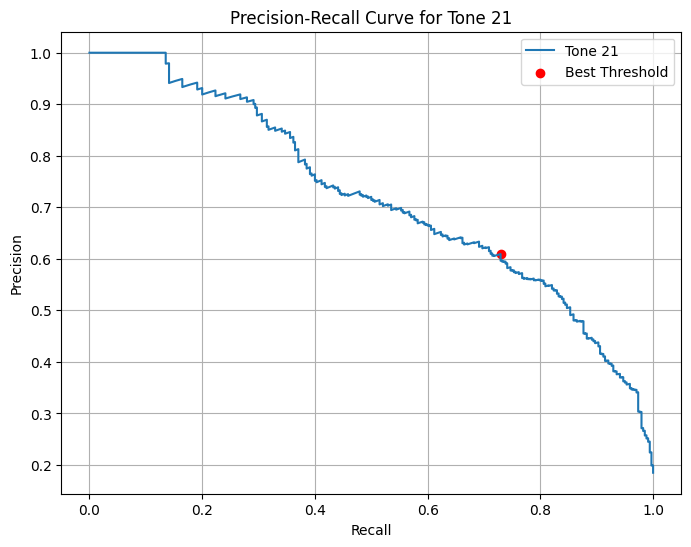

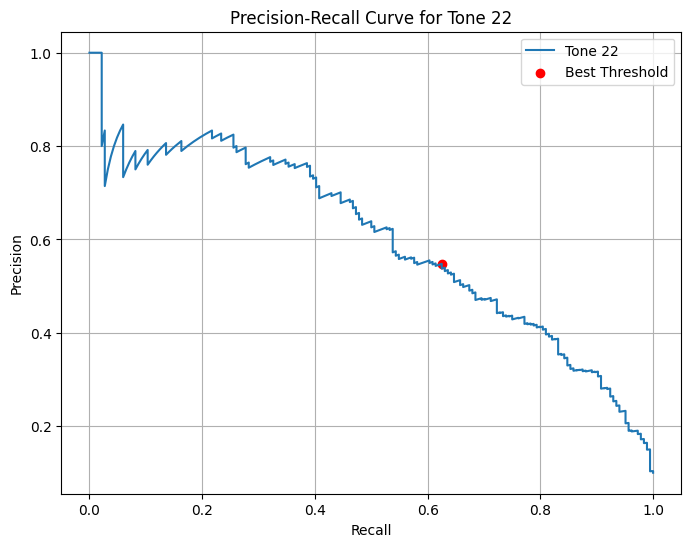

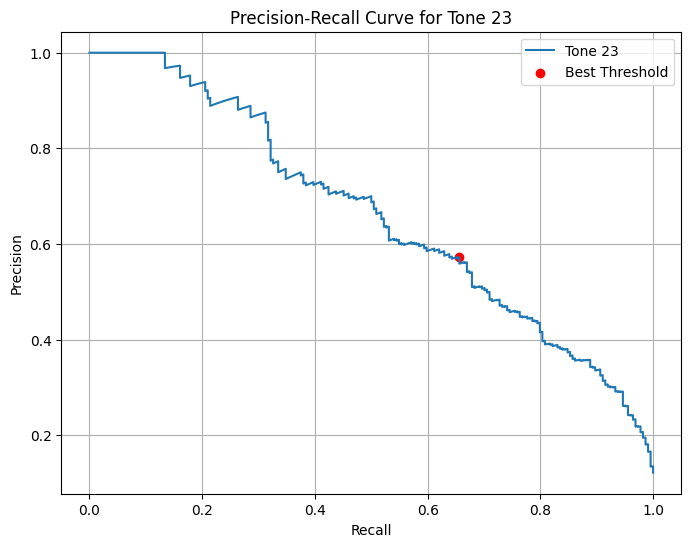

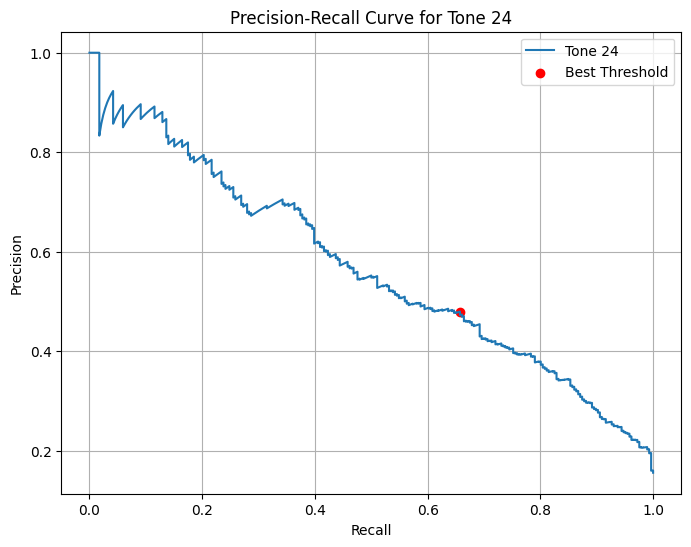

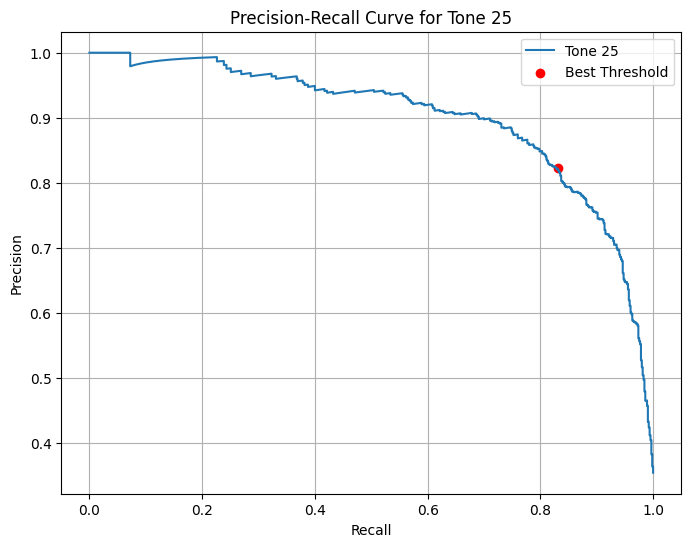

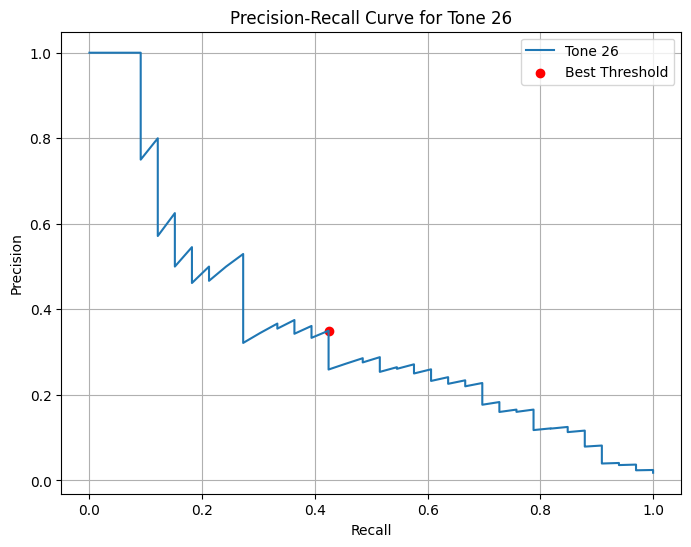

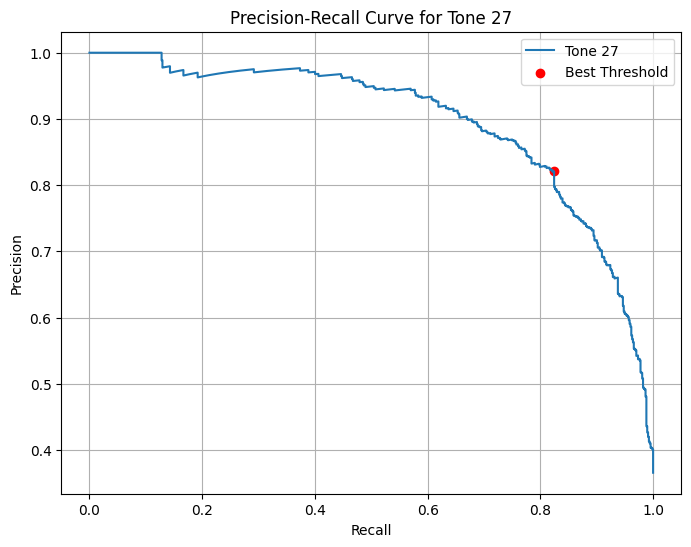

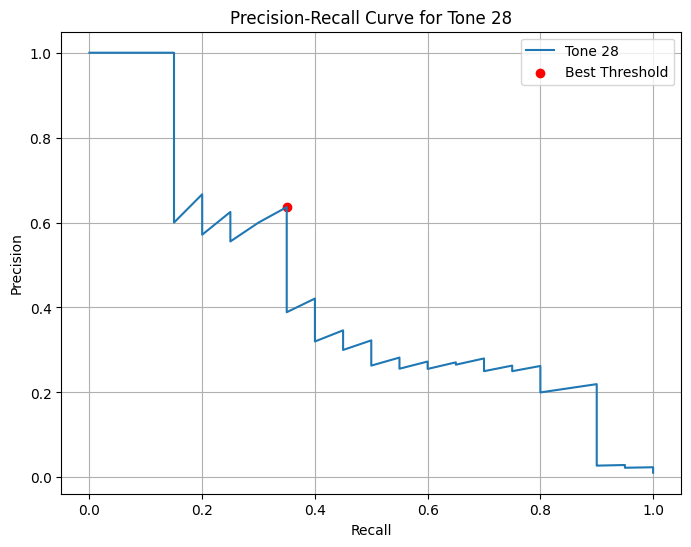

In [ ]:
for tone_idx, pr_data in pr_curves.items():
    best_threshold = best_thresholds[tone_idx]
    precision, recall, thresholds = pr_data['precision'], pr_data['recall'], pr_data['thresholds']
    best_idx = (thresholds == best_threshold).nonzero()[0][0]

    plt.figure(figsize=(8, 6))
    plt.plot(recall, precision, label=f'Tone {tone_idx}')
    plt.scatter(recall[best_idx], precision[best_idx], color='red', label='Best Threshold')
    plt.title(f'Precision-Recall Curve for Tone {tone_idx}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.grid()
    plt.show()


<a id='section06'></a>
### Evaluating the model Performance:

The model is evaluated on unseen data (20% of the generated_emotional_tones.tsv dataset) to assess its generalization ability. During validation, the model's weights are fixed, and predictions are compared to actual values to compute performance metrics.

**Results:**
The high accuracy and balanced precision and recall indicate that the model effectively predicts emotional tones on unseen data.

Final Test Metrics:

Loss = 0.1096

Accuracy = 96.48%

Precision = 0.8828

Recall = 0.8689

F1 Score = 0.8692

In [76]:
all_targets = np.array(all_targets)
all_probs = np.array(all_probs)

test_thresholds = find_best_thresholds(all_targets, all_probs)

valid_loss, valid_acc, precision, recall, f1 = valid(model, testing_loader, test_thresholds)

print(f"Final Test Metrics:  \nLoss = {valid_loss:.4f}\n Accuracy = {valid_acc * 100:.2f}%\n Precision = {precision:.4f}\n Recall = {recall:.4f}\n F1 Score = {f1:.4f}\n")

Final Test Metrics:  
Loss = 0.1096
 Accuracy = 96.48%
 Precision = 0.8828
 Recall = 0.8689
 F1 Score = 0.8692



<a id='section07'></a>
### Saving the Trained Model for Future Use

This is the final step in the fine-tuning process.

The model and its vocabulary are saved locally, allowing them to be used later for making predictions on new inputs, such as movie descriptions.

In [78]:
output_model_file = 'pytorch_roberta_emotional_tone_prediction_in_movies.bin'
output_vocab_file = './'

model_to_save = model
torch.save(model_to_save, output_model_file)
tokenizer.save_vocabulary(output_vocab_file)

print('All files saved successfully')
print('This tutorial is completed')

All files saved successfully
This tutorial is completed
